# Introduction




# Prepare for analysis

## Load packages

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))


from src.data import load_data, analyze_missing_data, analyze_frequent_data, analyze_unique_values
from src.features import (create_family_size, create_age_intervals, create_fare_intervals, 
                     create_sex_pclass_feature, create_family_type, standardize_titles,
                     extract_name_features, combine_datasets)
from src.model import encode_categorical_features, prepare_training_data, train_random_forest, evaluate_model
from src.utils import plot_count_pairs, plot_distribution_pairs, print_data_summary, get_feature_importance, plot_feature_importance


In [92]:
# TODO: Add all hard coded parameters like file paths or model parameters here
TRAIN_PATH = "../data/train.csv"
TEST_PATH = "../data/test.csv"

## Read the data

In [93]:


# TODO: Put the path at the top of the script and replace with variable
train_df, test_df = load_data(TRAIN_PATH, TEST_PATH)


# Preliminary data inspection

## Quick glimpse of the data
TODO: Think if you can abstract away much here.

In [94]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [95]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [96]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [97]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [98]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [99]:
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


## Few statistics on the data

### Missing data

In [100]:
# TODO: turn into function
# total = train_df.isnull().sum()
# percent = (train_df.isnull().sum()/train_df.isnull().count()*100)
# tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# types = []
# for col in train_df.columns:
#     dtype = str(train_df[col].dtype)
#     types.append(dtype)
# tt['Types'] = types
# df_missing_train = np.transpose(tt)
df_missing_train = analyze_missing_data(train_df)
print("Training set missing data:")
print(df_missing_train)

Training set missing data:
        PassengerId Survived Pclass    Name     Sex       Age  SibSp  Parch  \
Total             0        0      0       0       0       177      0      0   
Percent         0.0      0.0    0.0     0.0     0.0  19.86532    0.0    0.0   
Types         int64    int64  int64  object  object   float64  int64  int64   

         Ticket     Fare      Cabin  Embarked  
Total         0        0        687         2  
Percent     0.0      0.0  77.104377  0.224467  
Types    object  float64     object    object  


In [101]:
# Analyze missing data for test set using our custom function
df_missing_test = analyze_missing_data(test_df)
print("Test set missing data:")
print(df_missing_test)

Test set missing data:
        PassengerId Pclass    Name     Sex        Age  SibSp  Parch  Ticket  \
Total             0      0       0       0         86      0      0       0   
Percent         0.0    0.0     0.0     0.0  20.574163    0.0    0.0     0.0   
Types         int64  int64  object  object    float64  int64  int64  object   

             Fare      Cabin Embarked  
Total           1        327        0  
Percent  0.239234  78.229665      0.0  
Types     float64     object   object  


### Most frequent data

In [102]:
# TODO: turn into function
# total = train_df.count()
# tt = pd.DataFrame(total)
# tt.columns = ['Total']
# items = []
# vals = []
# for col in train_df.columns:
#     try:
#         itm = train_df[col].value_counts().index[0]
#         val = train_df[col].value_counts().values[0]
#         items.append(itm)
#         vals.append(val)
#     except Exception as ex:
#         print(ex)
#         items.append(0)
#         vals.append(0)
#         continue
# tt['Most frequent item'] = items
# tt['Frequence'] = vals
# tt['Percent from total'] = np.round(vals / total * 100, 3)
# np.transpose(tt)
frequent_train = analyze_frequent_data(train_df)
print("Training set most frequent data:")
print(frequent_train)

Training set most frequent data:
                   PassengerId Survived  Pclass                     Name  \
Total                      891      891     891                      891   
Most frequent item           1        0       3  Braund, Mr. Owen Harris   
Frequence                    1      549     491                        1   
Percent from total       0.112   61.616  55.107                    0.112   

                       Sex    Age   SibSp   Parch  Ticket   Fare    Cabin  \
Total                  891    714     891     891     891    891      204   
Most frequent item    male   24.0       0       0  347082   8.05  B96 B98   
Frequence              577     30     608     678       7     43        4   
Percent from total  64.759  4.202  68.238  76.094   0.786  4.826    1.961   

                   Embarked  
Total                   889  
Most frequent item        S  
Frequence               644  
Percent from total   72.441  


In [103]:
# TODO: turn into function
# total = test_df.count()
# tt = pd.DataFrame(total)
# tt.columns = ['Total']
# items = []
# vals = []
# for col in test_df.columns:
#     try:
#         itm = test_df[col].value_counts().index[0]
#         val = test_df[col].value_counts().values[0]
#         items.append(itm)
#         vals.append(val)
#     except Exception as ex:
#         print(ex)
#         items.append(0)
#         vals.append(0)
#         continue
# tt['Most frequent item'] = items
# tt['Frequence'] = vals
# tt['Percent from total'] = np.round(vals / total * 100, 3)
# np.transpose(tt)
frequent_test = analyze_frequent_data(test_df)
print("Testing set most frequent data:")
print(frequent_test)

Testing set most frequent data:
                   PassengerId  Pclass              Name     Sex   Age  \
Total                      418     418               418     418   332   
Most frequent item         892       3  Kelly, Mr. James    male  21.0   
Frequence                    1     218                 1     266    17   
Percent from total       0.239  52.153             0.239  63.636  5.12   

                     SibSp   Parch    Ticket   Fare            Cabin Embarked  
Total                  418     418       418    417               91      418  
Most frequent item       0       0  PC 17608   7.75  B57 B59 B63 B66        S  
Frequence              283     324         5     21                3      270  
Percent from total  67.703  77.512     1.196  5.036            3.297   64.593  


### Unique values

In [104]:
# Analyze unique values for training set using our custom function
unique_train = analyze_unique_values(train_df)
print("Training set unique values:")
print(unique_train)

Training set unique values:
         PassengerId  Survived  Pclass  Name  Sex  Age  SibSp  Parch  Ticket  \
Total            891       891     891   891  891  714    891    891     891   
Uniques          891         2       3   891    2   88      7      7     681   

         Fare  Cabin  Embarked  
Total     891    204       889  
Uniques   248    147         3  


In [105]:
# TODO: turn into function
# total = test_df.count()
# tt = pd.DataFrame(total)
# tt.columns = ['Total']
# uniques = []
# for col in test_df.columns:
#     unique = test_df[col].nunique()
#     uniques.append(unique)
# tt['Uniques'] = uniques
# np.transpose(tt)
unique_test = analyze_unique_values(test_df)
print("Testing set unique values:")
print(unique_test)


Testing set unique values:
         PassengerId  Pclass  Name  Sex  Age  SibSp  Parch  Ticket  Fare  \
Total            418     418   418  418  332    418    418     418   417   
Uniques          418       3   418    2   79      7      8     363   169   

         Cabin  Embarked  
Total       91       418  
Uniques     76         3  


# Exploratory data analysis

## Univariate analysis for all features


We show here two graphs in paralel:
* distribution of class values, split per Survived value
* comparison of class values, in train and test data


Let's first aggregate train and test data into one single dataframe, `all_df`.

In [106]:
# Combine datasets using our custom function
all_df = combine_datasets(train_df, test_df)

In [107]:
all_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,set
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train


/Users/ray/Desktop/Course/D100 Fundamentals of Data Science/PS1/ps1_ex4_nb_to_repo/notebooks/../src/utils.py:29: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=df, hue=hue, palette=color_list)


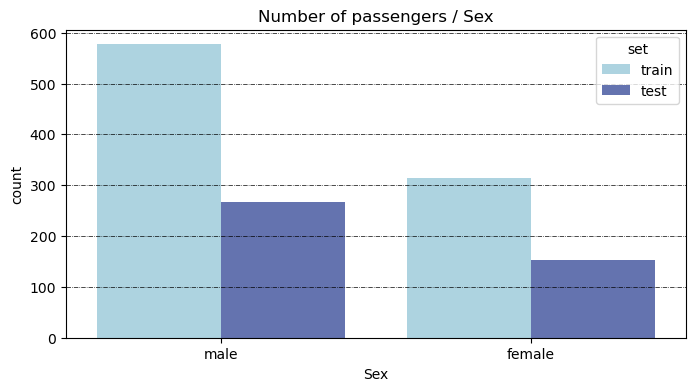

In [108]:
# Plot count pairs "Sex" using our custom function
color_list = ["#A5D7E8", "#576CBC", "#19376D", "#0b2447"]
plot_count_pairs(all_df, "Sex", hue="set", title="Number of passengers / Sex", color_list=color_list)  

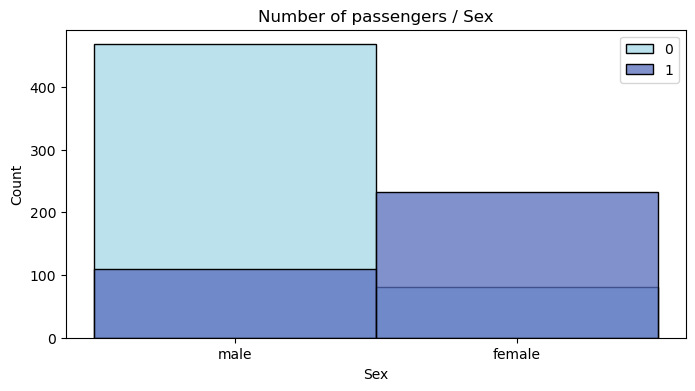

In [109]:
# Plot distribution pairs for "Sex" and hue as "Survived" using our custom function
color_list = ["#A5D7E8", "#576CBC", "#19376D", "#0b2447"]
plot_distribution_pairs(train_df, "Sex", hue="Survived", title="Number of passengers / Sex", color_list=color_list)

/Users/ray/Desktop/Course/D100 Fundamentals of Data Science/PS1/ps1_ex4_nb_to_repo/notebooks/../src/utils.py:29: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=df, hue=hue, palette=color_list)


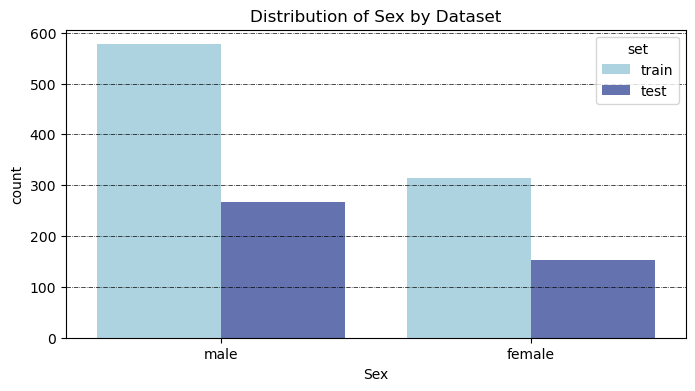

/Users/ray/Desktop/Course/D100 Fundamentals of Data Science/PS1/ps1_ex4_nb_to_repo/notebooks/../src/utils.py:29: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=df, hue=hue, palette=color_list)


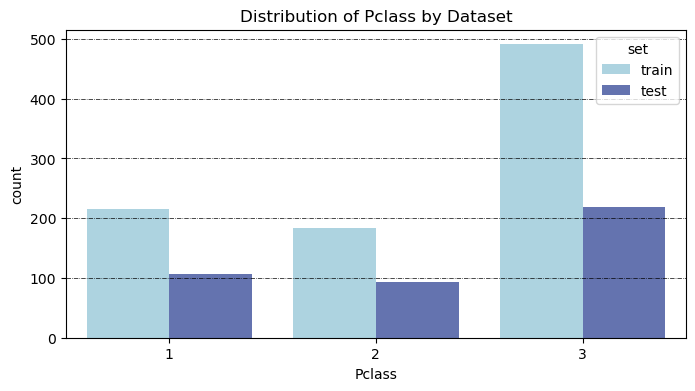

/Users/ray/Desktop/Course/D100 Fundamentals of Data Science/PS1/ps1_ex4_nb_to_repo/notebooks/../src/utils.py:29: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=df, hue=hue, palette=color_list)


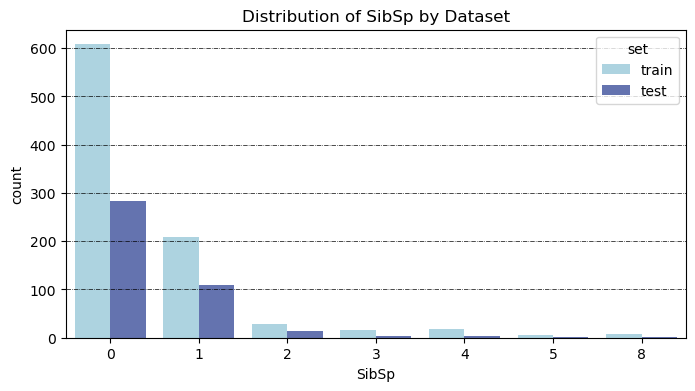

/Users/ray/Desktop/Course/D100 Fundamentals of Data Science/PS1/ps1_ex4_nb_to_repo/notebooks/../src/utils.py:29: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=df, hue=hue, palette=color_list)


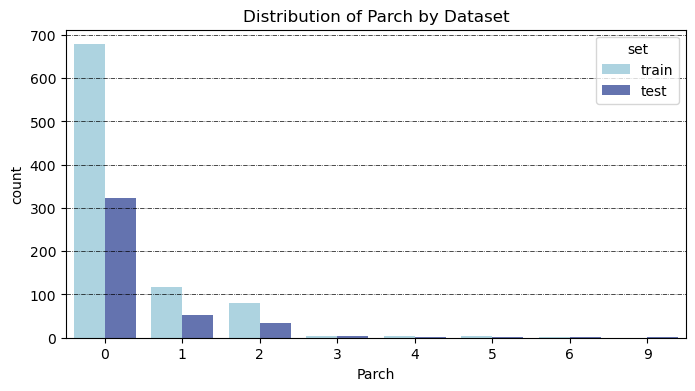

/Users/ray/Desktop/Course/D100 Fundamentals of Data Science/PS1/ps1_ex4_nb_to_repo/notebooks/../src/utils.py:29: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=df, hue=hue, palette=color_list)


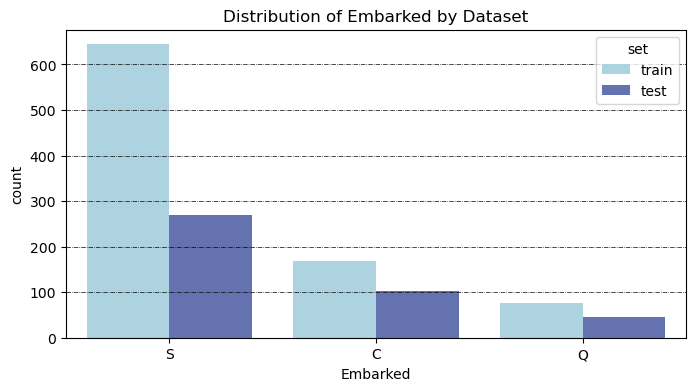

In [ ]:
# Plot count pairs using all_df for the columns: Sex, Pclass, SibSp, Parch, Embarked

# [Cell 25]
# Plot count pairs using all_df for the columns: Sex, Pclass, SibSp, Parch, Embarked


columns_to_plot = ["Sex", "Pclass", "SibSp", "Parch", "Embarked"]

for col in columns_to_plot:
    if col in all_df.columns:
        plot_count_pairs(all_df.reset_index(drop=True), col, hue="set", title=f"Distribution of {col} by Dataset", color_list=color_list)

/Users/ray/Desktop/Course/D100 Fundamentals of Data Science/PS1/ps1_ex4_nb_to_repo/notebooks/../src/utils.py:29: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=df, hue=hue, palette=color_list)


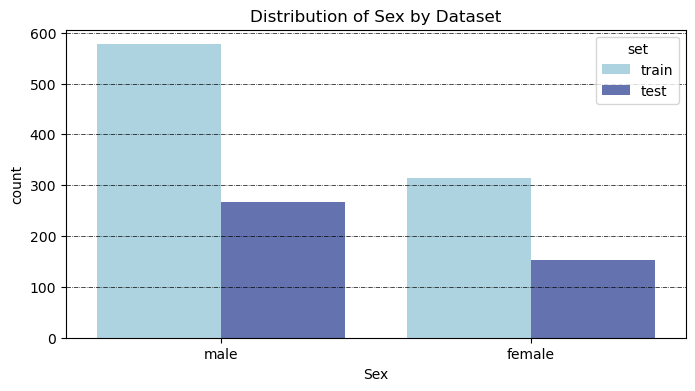

/Users/ray/Desktop/Course/D100 Fundamentals of Data Science/PS1/ps1_ex4_nb_to_repo/notebooks/../src/utils.py:29: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=df, hue=hue, palette=color_list)


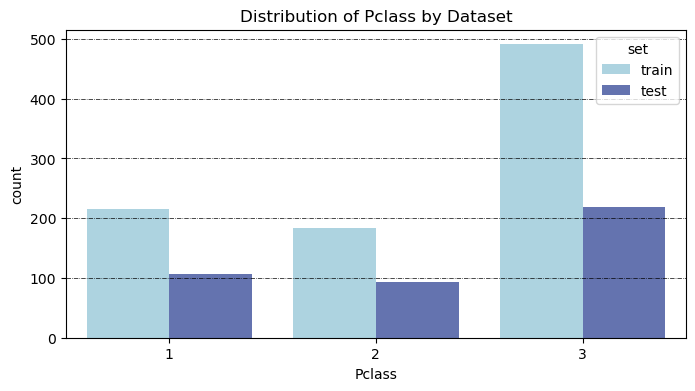

/Users/ray/Desktop/Course/D100 Fundamentals of Data Science/PS1/ps1_ex4_nb_to_repo/notebooks/../src/utils.py:29: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=df, hue=hue, palette=color_list)


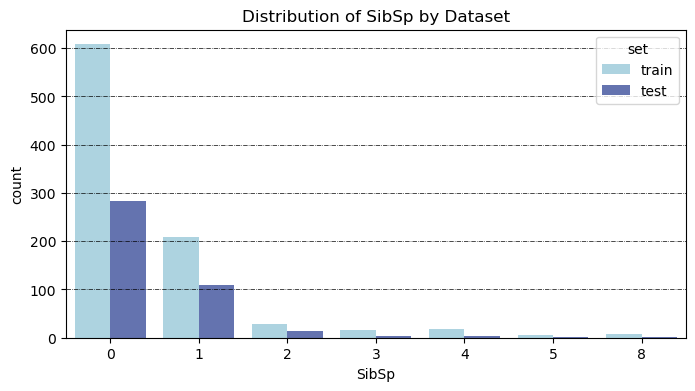

/Users/ray/Desktop/Course/D100 Fundamentals of Data Science/PS1/ps1_ex4_nb_to_repo/notebooks/../src/utils.py:29: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=df, hue=hue, palette=color_list)


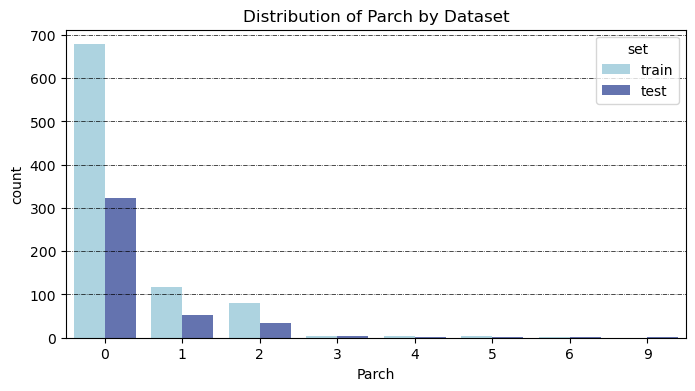

/Users/ray/Desktop/Course/D100 Fundamentals of Data Science/PS1/ps1_ex4_nb_to_repo/notebooks/../src/utils.py:29: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=df, hue=hue, palette=color_list)


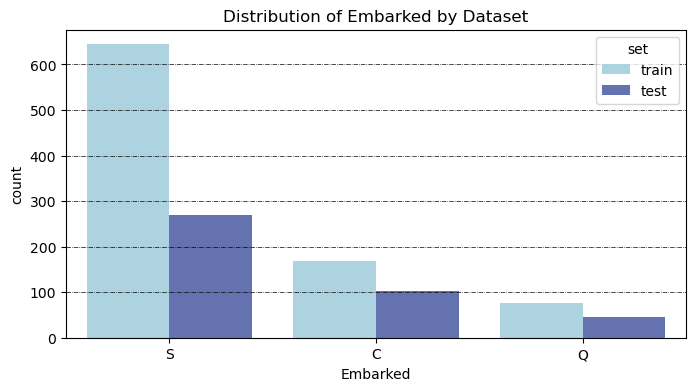

In [111]:
# Plot count pairs using all_df for the columns: Sex, Pclass, SibSp, Parch, Embarked
columns_to_plot = ["Sex", "Pclass", "SibSp", "Parch", "Embarked"]

for col in columns_to_plot:
    if col in all_df.columns:
        plot_count_pairs(all_df.reset_index(drop=True), col, hue="set", title=f"Distribution of {col} by Dataset", color_list=color_list)

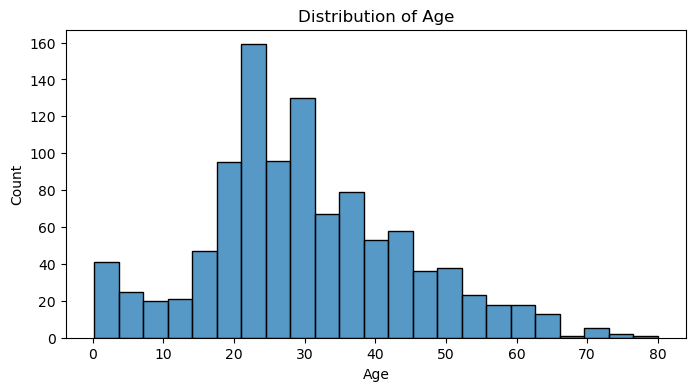

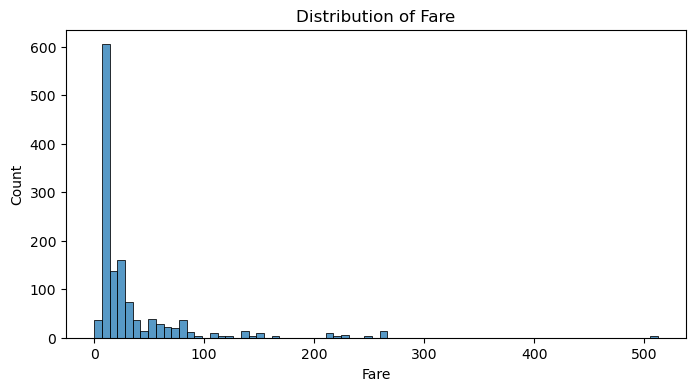

In [112]:
# Plot distribution pairs for Age and Fare
numeric_columns = ["Age", "Fare"]
for col in numeric_columns:
    if col in all_df.columns:
        plot_distribution_pairs(all_df.reset_index(drop=True), col, title=f"Distribution of {col}", color_list=color_list)

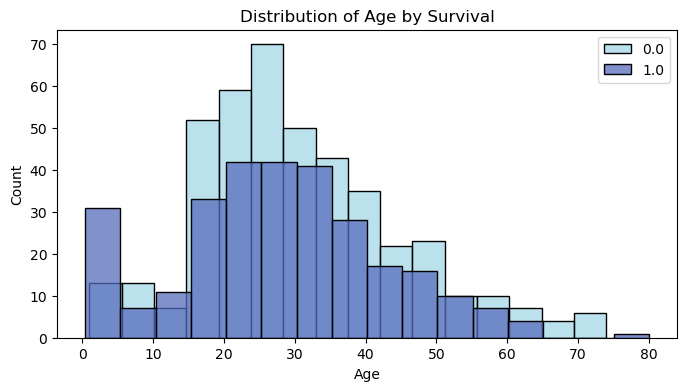

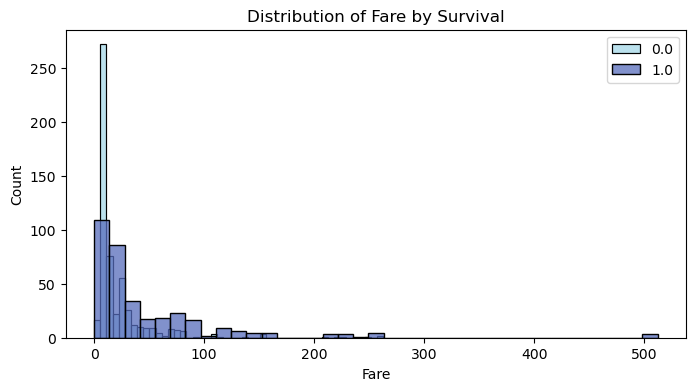

In [113]:
# Plot distribution pairs for Age and Fare using "Survived" as hue
numeric_columns = ["Age", "Fare"]
for col in numeric_columns:
    if col in all_df.columns:
        plot_distribution_pairs(all_df.reset_index(drop=True), col, hue="Survived", title=f"Distribution of {col} by Survival", color_list=color_list)

## Family size


Based on SibSp (sibilings or spouse) and Parch (parents or children), we set the Family Size field.

In [114]:
# Create family size feature using our custom function
all_df = create_family_size(all_df)

In [115]:
# Create family size feature for training set
train_df = create_family_size(train_df)


/Users/ray/Desktop/Course/D100 Fundamentals of Data Science/PS1/ps1_ex4_nb_to_repo/notebooks/../src/utils.py:29: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=df, hue=hue, palette=color_list)


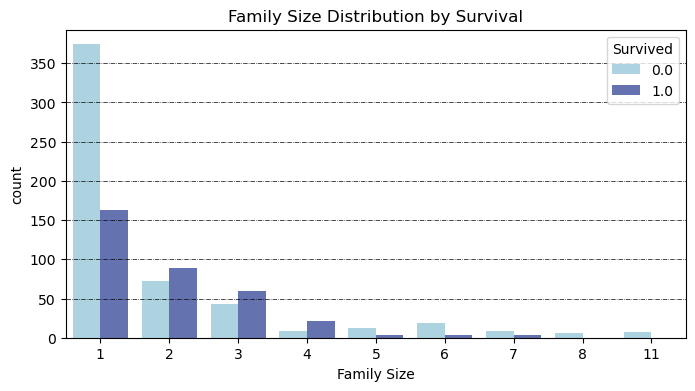

In [116]:
# Plot count pairs using all_df for the column "Family Size" and use "Survived" as hue
plot_count_pairs(all_df, "Family Size", hue="Survived", title="Family Size Distribution by Survival", color_list=color_list)

## Age interval

In [117]:
# Create age intervals using our custom function
all_df = create_age_intervals(all_df)

In [118]:
# Create age intervals for training set
train_df = create_age_intervals(train_df)

In [119]:
all_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,set,Family Size,Age Interval
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train,2,1.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train,2,2.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train,1,1.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train,2,2.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train,1,2.0


/Users/ray/Desktop/Course/D100 Fundamentals of Data Science/PS1/ps1_ex4_nb_to_repo/notebooks/../src/utils.py:29: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=df, hue=hue, palette=color_list)


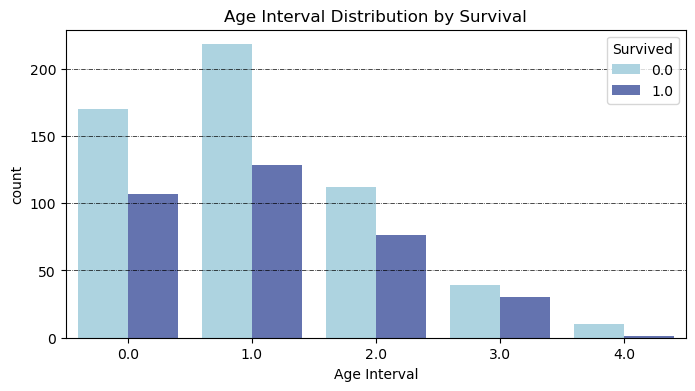

In [120]:
# Plot count pairs using all_df for the column "Age Interval" and use "Survived" as hue
plot_count_pairs(all_df, "Age Interval", hue="Survived", title="Age Interval Distribution by Survival", color_list=color_list)

## Fare interval

In [121]:
# Create fare intervals using our custom function
all_df = create_fare_intervals(all_df)

In [122]:
# Create fare intervals for training set
train_df = create_fare_intervals(train_df)

/Users/ray/Desktop/Course/D100 Fundamentals of Data Science/PS1/ps1_ex4_nb_to_repo/notebooks/../src/utils.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, palette=color_list)


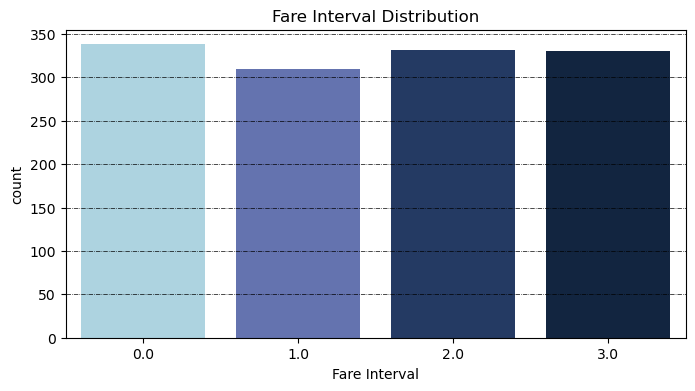

In [123]:
# Plot count pairs using all_df for the column "Fare Interval"
plot_count_pairs(all_df, "Fare Interval", title="Fare Interval Distribution", color_list=color_list)

Let's create a composed feature: Pclass + Sex.

In [124]:
# Create sex-pclass feature for training set
train_df = create_sex_pclass_feature(train_df)

In [125]:
# Create sex-pclass feature for combined dataset
all_df = create_sex_pclass_feature(all_df)

/Users/ray/Desktop/Course/D100 Fundamentals of Data Science/PS1/ps1_ex4_nb_to_repo/notebooks/../src/utils.py:29: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=df, hue=hue, palette=color_list)


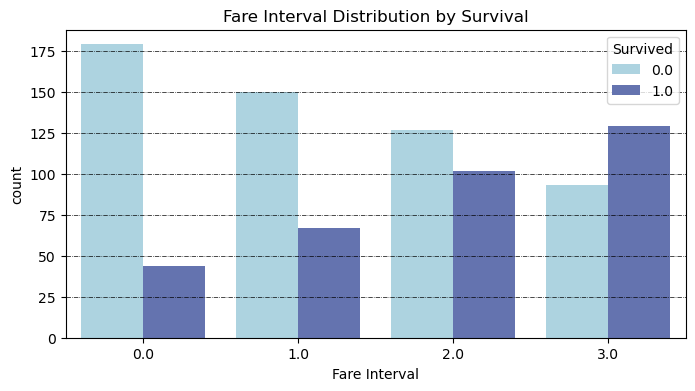

In [126]:
# Plot count pairs using all_df for the column "Fare Interval" and "Fare (grouped by survival)" with "Survived" as hue
plot_count_pairs(all_df, "Fare Interval", hue="Survived", title="Fare Interval Distribution by Survival", color_list=color_list)

## Process names


When we process names, we would like to extract the following information:

- Family name - this is the first word (or few first words, if a family name with multiple names), followed by a comma  
- Title - this follows just after the comma   
- Given name - this is the word or group of words following family name  
- Maiden name - for ladies, is given between parantheses  

We start with creating a function that parses the Name string and extract (if possible) these 4 elements


In [127]:
# Extract name features using our custom function
all_df = extract_name_features(all_df)
    
    

In [128]:
# Extract name features for training set
train_df = extract_name_features(train_df)

In [129]:
# Extract name features for test set
test_df = extract_name_features(test_df)

## Multivariate analysis


Let's look now to the interaction of multiple features.

/Users/ray/Desktop/Course/D100 Fundamentals of Data Science/PS1/ps1_ex4_nb_to_repo/notebooks/../src/utils.py:29: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.countplot(x=column, data=df, hue=hue, palette=color_list)


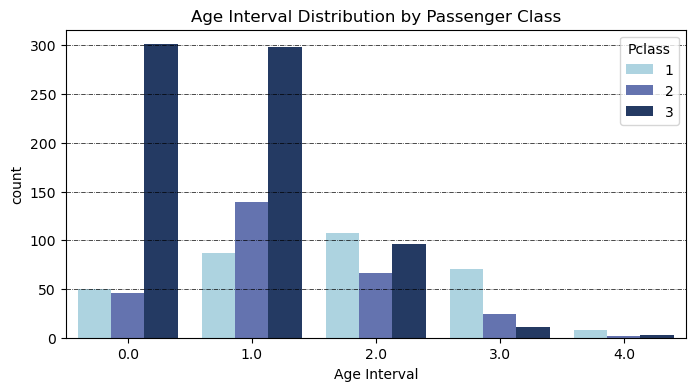

In [130]:
# Plot count pairs of "Age Interval" grouped by "Pclass"
plot_count_pairs(all_df, "Age Interval", hue="Pclass", title="Age Interval Distribution by Passenger Class", color_list=color_list)

/Users/ray/Desktop/Course/D100 Fundamentals of Data Science/PS1/ps1_ex4_nb_to_repo/notebooks/../src/utils.py:29: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.countplot(x=column, data=df, hue=hue, palette=color_list)


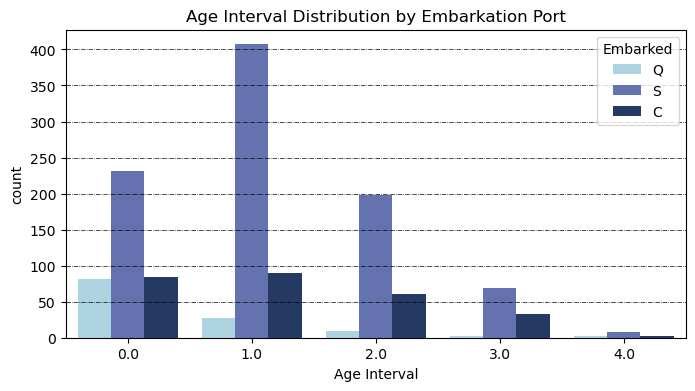

In [131]:
# Plot count pairs of "Age Interval" grouped by "Embarked"
plot_count_pairs(all_df, "Age Interval", hue="Embarked", title="Age Interval Distribution by Embarkation Port", color_list=color_list)

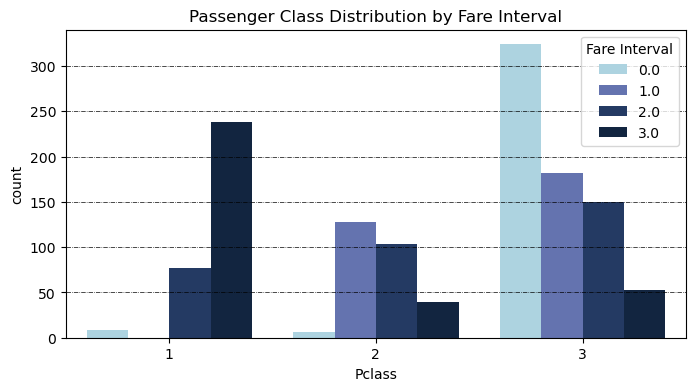

In [132]:
# Plot count pairs of "Pclass" grouped by "Fare Interval"
plot_count_pairs(all_df, "Pclass", hue="Fare Interval", title="Passenger Class Distribution by Fare Interval", color_list=color_list)

### Few more engineered data 


Let's create two more engineered features:  
* Family size interval: Single, Small, Large  
* Aggregated titles: Mr, Mrs, Master, Miss, and Rare  

In [133]:
# Create family type feature using our custom function
all_df = create_family_type(all_df)
train_df = create_family_type(train_df)

/Users/ray/Desktop/Course/D100 Fundamentals of Data Science/PS1/ps1_ex4_nb_to_repo/notebooks/../src/features.py:106: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Single' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df["Family Size"] == 1, "Family Type"] = "Single"
/Users/ray/Desktop/Course/D100 Fundamentals of Data Science/PS1/ps1_ex4_nb_to_repo/notebooks/../src/features.py:106: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Single' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df["Family Size"] == 1, "Family Type"] = "Single"


In [134]:
# Create family type feature for test set
test_df = create_family_size(test_df)
test_df = create_family_type(test_df)

/Users/ray/Desktop/Course/D100 Fundamentals of Data Science/PS1/ps1_ex4_nb_to_repo/notebooks/../src/features.py:106: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Single' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df["Family Size"] == 1, "Family Type"] = "Single"


In [135]:
for dataset in [all_df, train_df]:
    dataset["Titles"] = dataset["Title"]

In [136]:
# Standardize titles using our custom function
all_df = standardize_titles(all_df)
train_df = standardize_titles(train_df)
test_df = standardize_titles(test_df)

In [137]:
# Show title statistics
title_stats = train_df[['Titles', 'Sex', 'Survived']].groupby(['Titles', 'Sex'], as_index=False).mean()
print("Title statistics:")
print(title_stats)

Title statistics:
    Titles     Sex  Survived
0  Master.    male  0.575000
1    Miss.  female  0.702703
2      Mr.    male  0.156673
3     Mrs.  female  0.793651
4     Rare  female  1.000000
5     Rare    male  0.250000


# Baseline model

## Feature engineering: Map categorical value to numerical values

In [138]:
# Encode categorical features using our custom function
train_df = encode_categorical_features(train_df)
test_df = encode_categorical_features(test_df)

Create train-validation split.

In [139]:
# Data split is handled in the prepare_training_data function
VALID_SIZE = 0.2

Define predictor features and target feature.

In [140]:
predictors = ["Sex", "Pclass"]
target = 'Survived'

Define the training and validation data and labels.

In [141]:
# Prepare training data using our custom function
train_X, train_Y, valid_X, valid_Y = prepare_training_data(train_df, predictors, target)

Initialize the classifiction algorithm.

In [142]:
# Train Random Forest model using our custom function
model = train_random_forest(train_X, train_Y, random_state=42)

Fit the classifier with the training data.

In [143]:
# Model is already trained in the previous step

Predict the train data (to check the training classification error).

In [144]:
# Evaluate model on training data using our custom function
train_results = evaluate_model(model, train_X, train_Y)
print("Training set classification report:")
print(train_results['classification_report'])

Training set classification report:
              precision    recall  f1-score   support

Not Survived       0.75      0.99      0.86       444
    Survived       0.96      0.47      0.63       268

    accuracy                           0.79       712
   macro avg       0.86      0.73      0.74       712
weighted avg       0.83      0.79      0.77       712



Predict the validation data.

Validation set classification report:
              precision    recall  f1-score   support

Not Survived       0.73      0.96      0.83       105
    Survived       0.90      0.49      0.63        74

    accuracy                           0.77       179
   macro avg       0.81      0.72      0.73       179
weighted avg       0.80      0.77      0.75       179


=== Feature Importance Analysis ===
Feature importance:
  feature  importance
0     Sex    0.734385
1  Pclass    0.265615


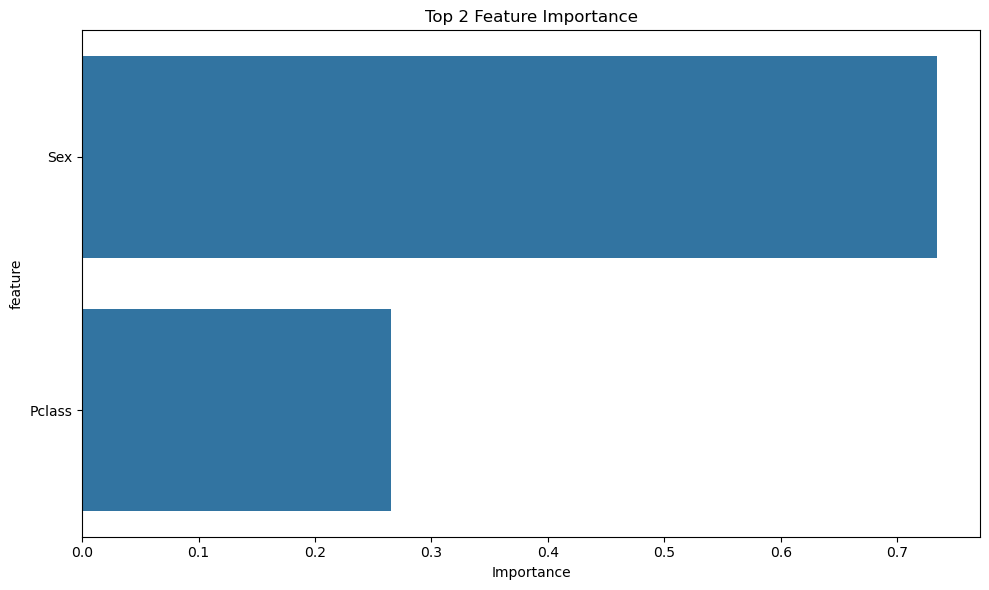

In [145]:
# Evaluate model on validation data using our custom function
valid_results = evaluate_model(model, valid_X, valid_Y)
print("Validation set classification report:")
print(valid_results['classification_report'])

# Feature importance analysis
print("\n=== Feature Importance Analysis ===")
importance_df = get_feature_importance(model, predictors)
print("Feature importance:")
print(importance_df)

# Plot feature importance
plot_feature_importance(importance_df, top_n=len(predictors))

# Evaluation

## Classification report for training data.

In [146]:
# Classification report is already printed in the previous step

Classification report for validation data.

In [147]:
# Classification report is already printed in the previous step

# Data summary
print("\n=== Data Summary ===")
print_data_summary(train_df, "Training Set")
print_data_summary(test_df, "Test Set")


=== Data Summary ===

=== Training Set Summary ===
Shape: (891, 22)
Columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Family Size', 'Age Interval', 'Fare Interval', 'Sex_Pclass', 'Family Name', 'Title', 'Given Name', 'Maiden Name', 'Family Type', 'Titles']
Data types:
PassengerId        int64
Survived           int64
Pclass             int64
Name              object
Sex                int64
Age              float64
SibSp              int64
Parch              int64
Ticket            object
Fare             float64
Cabin             object
Embarked          object
Family Size        int64
Age Interval     float64
Fare Interval    float64
Sex_Pclass        object
Family Name       object
Title             object
Given Name        object
Maiden Name       object
Family Type       object
Titles            object
dtype: object
Missing values:
PassengerId        0
Survived           0
Pclass             0
Name      